# 6-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [6]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

## 1) 데이터 준비와 확인

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)  # 단어사전에 등재할 단어 개수 지정
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.6.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [8]:
# 데이터 확인
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


## 1-2. 단어사전 확인 및 가공

In [8]:
# 단어사전 확인
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])      # 'the' 가 출력됩니다.
print(word_to_index['the'])  # 1 이 출력됩니다.

1654784/1641221 [==============================] - 0s 0us/step
the
1


In [9]:
# index를 3씩 뒤로 밀기
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 4개 인덱스는 사전에 정의된 것으로 추가
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

# 변경된 인덱스 확인
print(index_to_word[1])      # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 가 출력됩니다.
print(index_to_word[4])      # 'the' 가 출력됩니다.

<BOS>
4
the


In [10]:
# decode한 문장과 라벨을 비교하여 일치하는지 확인
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [18]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from konlpy.tag import Mecab
import numpy as np
from collections import Counter


tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [20]:
index_to_word = {index:word for word, index in word_to_index.items()}

## 1-3. 모델 구성을 위한 데이터 분석 및 가공

In [21]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예시) 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [26]:
# padding으로 문장 길이 맞추기
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post', # 혹은 'pre'
                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post', # 혹은 'pre'
                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [27]:
X = x_train[:100000]
y = y_train[:100000]
x_val = x_train[100000:]
y_val = y_train[100000:]

# 2. 딥러닝 모델 설계와 훈련

## 2-1. 모델 설계

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 훈련용 데이터셋 25000건 중 10000건을 분리하여 validation set으로 사용
x_val = x_train[:10000]  
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건은 train set
partial_x_train = x_train[10000:] 
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


# 2-2. 모델 훈련

In [21]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=2)

Epoch 1/10
30/30 - 3s - loss: 0.5784 - accuracy: 0.7597 - val_loss: 0.5609 - val_accuracy: 0.7440
Epoch 2/10
30/30 - 1s - loss: 0.5825 - accuracy: 0.7120 - val_loss: 0.5666 - val_accuracy: 0.7217
Epoch 3/10
30/30 - 1s - loss: 0.5306 - accuracy: 0.7664 - val_loss: 0.5813 - val_accuracy: 0.7513
Epoch 4/10
30/30 - 1s - loss: 0.5326 - accuracy: 0.7781 - val_loss: 0.5476 - val_accuracy: 0.7628
Epoch 5/10
30/30 - 1s - loss: 0.6855 - accuracy: 0.6682 - val_loss: 0.9533 - val_accuracy: 0.5190
Epoch 6/10
30/30 - 1s - loss: 0.7193 - accuracy: 0.6336 - val_loss: 0.5988 - val_accuracy: 0.7560
Epoch 7/10
30/30 - 1s - loss: 0.5401 - accuracy: 0.7791 - val_loss: 0.5598 - val_accuracy: 0.7477
Epoch 8/10
30/30 - 1s - loss: 0.5228 - accuracy: 0.7803 - val_loss: 0.5503 - val_accuracy: 0.7615
Epoch 9/10
30/30 - 1s - loss: 0.5148 - accuracy: 0.7900 - val_loss: 0.5513 - val_accuracy: 0.7593
Epoch 10/10
30/30 - 1s - loss: 0.5131 - accuracy: 0.7881 - val_loss: 0.5540 - val_accuracy: 0.7553


In [22]:
# test set으로 model 평가
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

782/782 - 5s - loss: 0.5619 - accuracy: 0.7488
[0.5618936419487, 0.7488399744033813]


## 2-3. Loss, Accuracy 그래프 시각화

In [23]:
# history 변수에 저장된 항목 확인
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


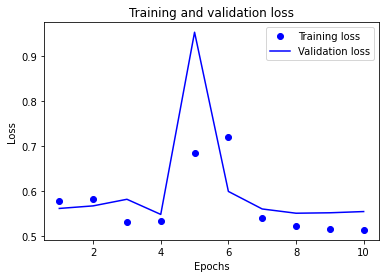

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')  # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 3. Word2Vec의 적용

### 3-1. 학습된 Embedding 레이어 분석

In [25]:
# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.04504767, -0.07745239, -0.00593156, -0.07198162, -0.01784263,
       -0.00328681, -0.06070649,  0.05011696, -0.02296268,  0.0649903 ,
       -0.07696186,  0.05450249,  0.01509404, -0.00955022,  0.0686805 ,
       -0.06397891], dtype=float32)

In [29]:
# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("like")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('seven', 0.9350764155387878),
 ('makes', 0.9257311224937439),
 ('glad', 0.9237133264541626),
 ('top', 0.9197701215744019),
 ('abandoned', 0.9146977066993713),
 ('mouthed', 0.9138608574867249),
 ('favorites', 0.9137330651283264),
 ('fully', 0.9132468104362488),
 ('doris', 0.9111425876617432),
 ('resist', 0.9103097319602966)]

### 3-2. Word2Vec 임베딩 활용하여 성능 개선

In [2]:
from gensim.models import Word2Vec
import os
word2vec_path = os.getenv('HOME')+'/aiffel/Exploration/Exploration_06/ko.bin'
word2vec = Word2Vec.load(word2vec_path) # 메모리가 많이 소모되므로 가장 많이 사용되는 상위 100만개로 limit
vector = word2vec['굳']
vector     # 300dim의 워드 벡터

/tmp/ipykernel_624/127125989.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['굳']


array([-1.007806  ,  0.02528994,  1.298106  , -0.60845226, -0.54713094,
       -0.21371064,  0.13086885,  1.0785574 , -0.10013311,  0.33208925,
       -0.9791137 , -0.18183775, -1.4690981 ,  0.3885967 ,  0.4037741 ,
        0.41902122,  0.43593058, -0.69959414,  0.85953486, -1.720156  ,
       -0.13397624,  0.12760656,  0.00936507,  1.517197  ,  0.44761622,
        0.21009429,  0.59510446, -1.155584  , -0.02006225, -0.7506223 ,
        0.65521383,  0.96242464, -0.54606813, -0.2683764 ,  0.861321  ,
       -0.4421176 ,  0.71351266,  0.68796396, -0.34496003, -0.1751155 ,
        0.9672179 ,  1.3559934 ,  0.47632736, -0.46820235,  0.8295786 ,
       -0.49501127,  1.621534  ,  0.4855655 ,  0.169487  , -0.2699588 ,
       -0.8880298 , -1.1619668 , -0.2655645 ,  0.8749546 , -0.89623314,
       -0.249976  , -1.511624  , -1.4201334 ,  1.3836174 ,  0.76095176,
        1.7128066 ,  1.6338425 ,  0.97855914, -0.58630663,  0.04052142,
        1.4990216 , -0.6120709 ,  0.34216446,  1.2269781 , -0.73

In [3]:
# 유사한 단어와 그 유사도 확인
word2vec.similar_by_word("사랑")  # 학습이 잘 되어 유사함

/tmp/ipykernel_624/464520198.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")  # 학습이 잘 되어 유사함


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [15]:
import numpy as np
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_624/253393674.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_624/253393674.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1460224   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
196/196 [==============================] - 15s 69ms/step - loss: 0.6325 - accuracy: 0.5916 - val_loss: 0.4608 - val_accuracy: 0.7794
Epoch 2/5
196/196 [==============================] - 14s 70ms/step - loss: 0.3730 - accuracy: 0.8348 - val_loss: 0.3350 - val_accuracy: 0.8540
Epoch 3/5
196/196 [==============================] - 14s 70ms/step - loss: 0.2927 - accuracy: 0.8763 - val_loss: 0.3189 - val_accuracy: 0.8625
Epoch 4/5
196/196 [==============================] - 14s 71ms/step - loss: 0.2521 - accuracy: 0.8965 - val_loss: 0.3180 - val_accuracy: 0.8666
Epoch 5/5
196/196 [==============================] - 14s 73ms/step - loss: 0.2113 - accuracy: 0.9151 - val_loss: 0.3307 - val_accuracy: 0.8607


In [30]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)   # 정확도가 0.85으로 개선됨

1537/1537 - 5s - loss: 0.3352 - accuracy: 0.8581
[0.3352018892765045, 0.8581483960151672]
